### TDSE: Time Dependent Schrodinger Equation 1D
$$
i\hbar \frac{d \psi (x,t)}{dt} = \frac{-\hbar^2}{2m} \frac{\partial^2 \psi (x,t)}{\partial x} + V(x,t) \psi (x,t)
\\
i\frac{\partial \psi}{\partial t'} = -\frac{1}{2}\frac{\partial^2 \psi}{\partial x'^2 } + V'(x)\psi
$$
#### Finite diferenece
$$
i\frac{\psi^{m+1}_{j} + \psi^{m}_{j}}{\Delta t} = -\frac{1}{2} \frac{\psi^{m}_{j+1} -2\psi^{m}_{j} + \psi^{m}_{j-1}}{\Delta x ^2} + V(x)\psi^{m}_{j} 
$$
$\psi$ of next time step at the position $j$
$$
\psi^{m+1}_{j} = \psi^{m}_{j} + \frac{i\Delta t}{2\Delta x^2}[\psi^{m}_{j+1} -2\psi^{m}_{j} + \psi^{m}_{j-1}] -i\Delta t V(x) \psi^{m}_{j} 
$$

## Gauusian wave packets equation
$\hbar$ and $m = 1$
$$
\psi_x(x,t = 0) = \left(\frac{1}{2\pi\sigma^2_x}\right)^\frac{1}{4} exp(ip_0x -\frac{(x-x_0)^2}{4\sigma^2_x})
$$

## Position, Momentum and Energy
### Operators
$$
\braket{o} = \int{}{} \psi^* o \psi dx 
$$
position
$$
\hat{x} = x
$$
linear momentum
$$
\hat{p} = -i\hbar\frac{\partial}{\partial x}
$$
Energy
$$
\hat{H} = -\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + V(x)
$$


In [9]:
# requirements and imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs


In [24]:
# System parameters 
N = 201
# positive length
L = 1
# grid
x,dx = np.linspace(0,L, N , retstep= True)
# time parameters
T = 0.0001
Nt = 5000
dt = 1e-4

In [25]:
# gaussain wave package generator
def gen_gaussian(x,x0,sigma, p0):
    A = (1 / (2 * np.pi * sigma**2))**(0.25)
    B = np.exp((-(x-x0)**2) / ((4 * sigma)**2))
    C = np.exp(1j*p0*x)
    return A * B * C

# standing wave generator
def gen_sine(x, n):
    A = np.sqrt(2/(L))
    k = np.pi/(L)
    return A * np.sin(n*k*x)

# potential
def V_2(x):
    return 1/2 * x 

def V_free_particle(x):
    return x * 0 

def V_well(x):
    mu ,sigma = 5 , 2
    A = -1e2
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

def V_harmonic(x):
    k = 5
    x0 = 5
    return 1/2 * k * (x-x0)**2 

def V_barrier(x,peak):
    arr = x.copy()
    arr[:] = 0 
    left = int(len(x) * 1/2)
    right = int(len(x) * (1/2 + 1/4)) 
    arr[left:right]  = peak
    return arr

def V_step(x,peak = 50):
    arr = x.copy()
    arr[:] = 0 
    left = int(len(x) * 1/2)
    arr[left:]  = peak
    return arr

# position operator
def get_position(psi):
    op_x = np.conj(psi) * x * psi
    return integrate.simps(op_x,x)

# momentum operator
def get_momentum(psi):
    op_p = np.conj(psi) * -1j * np.gradient(psi,1)
    return  integrate.simps(op_p,x)

# Energy 
def get_e(psi,V):
    d2 = np.gradient(np.gradient(psi,x),x)
    ke = - 1/2 * d2
    po = V * psi
    op_e = np.conj(psi) * (ke + po)
    return integrate.simps(op_e,x)

# probability density
def density(psi):
    return psi * np.conj(psi)

#normalize wave function
def normalize(psi, x):
    sum_psi_sq = integrate.simps(abs(psi)**2 , x)
    return 1/np.sqrt(sum_psi_sq) * psi 

# check normalization
def check_normal(psi):
    psi_n = [integrate.simps(abs(psi[n])**2 , x) for n in range(101)]
    cnor = np.ones(101)
    return psi_n - cnor < 1e-9

# compute psi[t+1] and normalise
def get_psi(psi,V):
    psi_next = np.zeros(N,dtype='cfloat')
    for i in range(1,len(psi)-1):
        # print(f'{psi[i]},{1j/2 * dt/dx**2 * (psi[i+1] - 2*psi[i] + psi[i-1])},{1j*dt*V(psi[i])*psi[i]}')
        psi_next[i] = psi[i] + (1j/2 * dt/dx**2 * (psi[i+1] - 2*psi[i] + psi[i-1])) - (1j*dt*V[i]*psi[i])
    psi_next = normalize(psi_next,x)
    return psi_next

# stack all psi[t] into big matrix
def simulation(psi,V):
    t = 0
    psi_tot = psi.copy()
    while t < Nt:
        psi = get_psi(psi,V)
        psi_tot = np.vstack((psi_tot,psi))
        t = t + 1 

    return psi_tot




C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


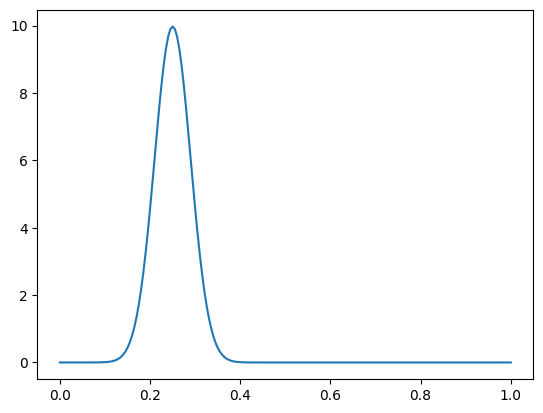

In [27]:
# psi0 as gaussian
psi = gen_gaussian(x, x0 = 0.25 , sigma = 1/50 , p0 = 0)
psi = normalize(psi,x)

# psi = np.abs(np.sin(x * np.pi / 10) + 2*np.sin(2 *x * np.pi/10))
# psi = normalize(psi,x)

# psi0 as ground state
# psi = gen_sine(x,2)
# psi = normalize(psi,x)

#psi1 as 2nd ground state
# psi = gen_sine(x,2)
# psi = normalize(psi,x)


# V = V_well(x)
plt.plot(x,density(psi))
# plt.plot(x,V)



In [28]:
# potential init
V0 = V_free_particle(x)
# simulation
psi_m00 = simulation(psi.astype(complex),V0)


C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


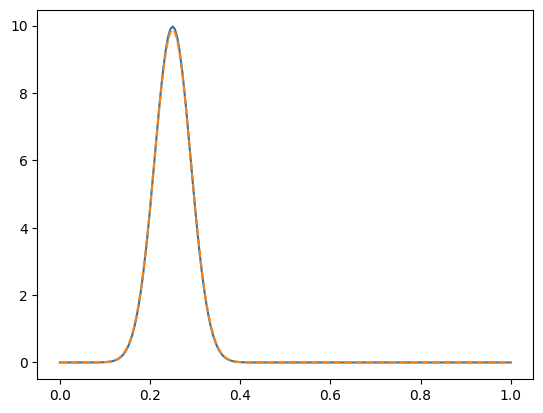

In [41]:
plt.plot(x,density(psi_m00[0]))

plt.plot(x,density(psi_m00[5]), '--')


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


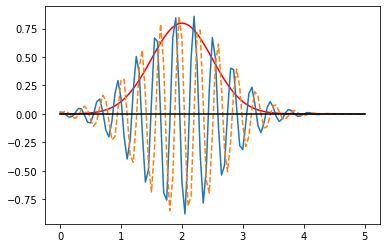

0.002 0.014142135623730952


In [359]:
plt.plot(x,density(psi), color = 'r')
plt.plot(x,psi.real)
plt.plot(x,psi.imag,'--')
plt.plot(x,V0,color = 'Black')
# plt.ylim(-1,1)
# plt.plot(x,density(get_psi(psi)))
plt.show()
# plt.plot(V0)

print(dt/dx , 1/100 * np.sqrt(2))


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(10001, 101)

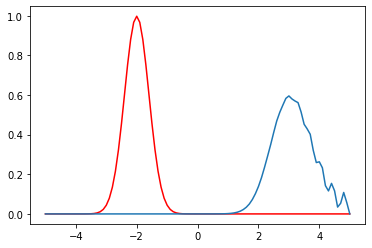

In [7]:
plt.plot(x,density(psi_m00[0]) , 'r')
plt.plot(x,density(psi_m00[-1]))
# plt.plot(x,psi_m00.real[-1])
# plt.plot(x,psi_m00[0])
# plt.plot(x,psi_m00[-1])

# t1  = 1j * (psi_m00[0] + psi_m00[1]) / dt 
# t2 =  -1/2 * ( psi_m00[1] - 2*psi_m00[0]) / dx**2

# t1-t2 < 1e-4

psi_m00.dtype
psi_m00.shape

C:\Users\Admin\AppData\Local\Temp/ipykernel_22916/663953017.py:1: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  round(get_momentum(psi_m00[0,:]),3)


(-0.902-0j)

C:\Users\Windows10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Windows10\AppData\Local\Temp\ipykernel_12100\2681721678.py:17: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return f'position <x> {round(get_position(psi_mm[sframe,:]),3).real}'
C:\Users\Windows10\AppData\Local\Temp\ipykernel_12100\2681721678.py:19: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return f'momentum <p> {round(get_momentum(psi_mm[sframe,:]),3).real}'
C:\Users\Windows10\AppData\Local\Temp\ipykernel_12100\2681721678.py:

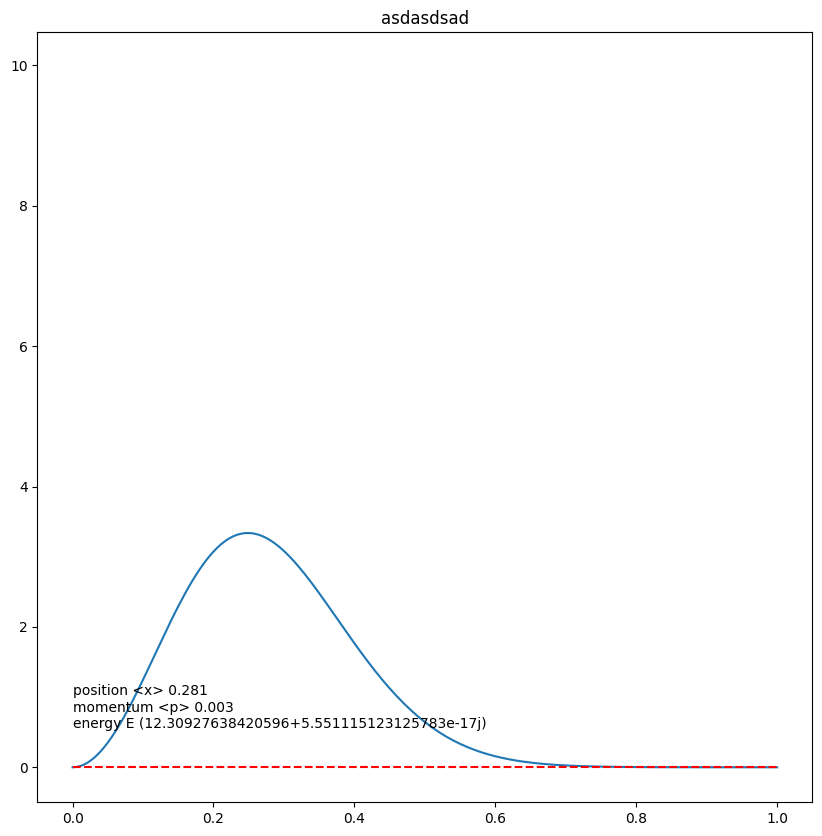

In [31]:
# animation
from matplotlib.animation import FuncAnimation
import os
# method used
psi_mm = psi_m00

#calculate E
# E = get_e(psi_mm)


fig,ax = plt.subplots(figsize  = (10,10))
line, = ax.plot(x,density(psi_mm[0,:]))
line2, = ax.plot(x, V0 , '--' ,color = 'r')
title = "asdasdsad"

def text_pos(sframe):
    return f'position <x> {round(get_position(psi_mm[sframe,:]),3).real}'
def text_momentum(sframe):
    return f'momentum <p> {round(get_momentum(psi_mm[sframe,:]),3).real}'
def text_energy(sframe):
    return f'energy E {get_e(psi_mm[sframe,:],V0)}'
txt = ax.text(0 , 0.85 ,f'{text_pos(0)} \n{text_momentum(0)} \n{text_energy(0)}', ha='left', va='center', fontsize=10, color="black")
plt.title(title)
# plt.ylim(-1,1)

# function update 1d wave over time
def update(frame):
    line.set_ydata(density(psi_mm[50 * frame,:]))
    txt.set_text(f'{text_pos(50*frame)} \n{text_momentum(50*frame)} \n{text_energy(50 * frame)}')
    return line, txt,



#number of frames 
nframes = len(psi_mm) // 50

ani = FuncAnimation(fig,update, frames = nframes, interval = 1, blit = True)


# save animation
file_format = 'gif'
file_name = f'1D TDSE v1 {title}'

directory = '/Users/Windows10/Desktop/schrodinger/animation'
output_file = os.path.join(directory, f'{file_name}.{file_format}')

ani.save(output_file, writer='pillow', fps=15)

plt.show()


In [246]:
# comparing Es 
get_e(psi_m01) / get_e(psi_m00)



3.999013120731215